In [91]:
import pandas as pd
import sys
sys.path.append('../src') 
from data_loader import ChestXray8Dataset
from models.cnn import ResNet50
from sklearn.model_selection import train_test_split
import time
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import tqdm # Progession bar
from matplotlib.pyplot import imread
from PIL import Image

# Configuration settings
data_dir = Path.cwd().parent / 'data'
results_dir = Path.cwd().parent / 'results'
images_dir = data_dir / 'images'
metadata_dir = data_dir /'metadata'/ 'Data_Entry_2017_v2020.csv'
train_val_path = data_dir /'metadata'/ 'train_val_list.txt'
test_path = data_dir / 'metadata' /'test_list.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [92]:
random_seed = 33 
np.random.seed(random_seed)
torch.manual_seed(random_seed)

train_val = pd.read_csv(train_val_path)
# Dividir en train y val
train, val= train_test_split(train_val, test_size=0.2, random_state=42)
train_size= len(train)
val_size = len(val)
train_path = data_dir /'metadata'/'train.txt'
val_path = data_dir /'metadata'/'val.txt'
train.to_csv(train_path,index=False)
val.to_csv(val_path,index=False)

In [93]:
metadata_df = pd.read_csv(metadata_dir)
train_df = metadata_df[metadata_df["Image Index"].isin(train)]
val_df = metadata_df[metadata_df["Image Index"].isin(val)]


In [94]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
from imageio import imread

class NIH(Dataset):
    def __init__(self, img_dir, metadata_file, split_file=None, transform=None):
        self.img_dir = img_dir
        self.metadata = pd.read_csv(metadata_file)
        
        # Filtrar las imágenes según el archivo de split (train/val/test)
        if split_file is not None:
            with open(split_file, 'r') as f:
                split_list = [line.strip() for line in f.readlines()]
            self.metadata = self.metadata[self.metadata['Image Index'].isin(split_list)]
        
        # Establecer las transformaciones, por defecto será un tensor
        self.transform = transform or transforms.Compose([transforms.ToTensor()])
        
        # Definición de las etiquetas, de acuerdo con ChestXray8
        self.PRED_LABEL = [
            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
        ]
        self.label_mapping = {label: idx for idx, label in enumerate(self.PRED_LABEL)}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        try:
            # Obtener el nombre de la imagen y cargarla
            img_name = os.path.join(self.img_dir, self.metadata.iloc[idx, 0])
            image = Image.open(img_name).convert("RGB")  # Asegurar que sea RGB

            # Obtener las etiquetas (separadas por '|') y convertirlas a tensor
            raw_labels = self.metadata.iloc[idx, 1]
            labels = raw_labels.split('|')
            label_tensor = torch.zeros(len(self.PRED_LABEL))  # Un tensor de ceros para 14 clases
            
            # Asignar 1 a las etiquetas correspondientes
            for label in labels:
                if label in self.label_mapping:
                    label_idx = self.label_mapping[label]
                    label_tensor[label_idx] = 1
            
            # Aplicar las transformaciones si están definidas
            if self.transform:
                image = self.transform(image)
            
            return image, label_tensor

        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            raise


In [95]:
class ChestXrayDataset(Dataset):
    def __init__(self, img_dir, metadata_file, split_file=None, transform=None, finding="any"):
        """
        Parameters:
        - img_dir: str, path to the directory containing images.
        - metadata_file: str, path to the CSV file containing metadata.
        - split_file: str, optional, path to a file listing specific images to include.
        - transform: torchvision.transforms, optional, transformations to apply to images.
        - finding: str, optional, filter dataset for a specific finding (default="any").
        """
        self.img_dir = img_dir
        self.metadata = pd.read_csv(metadata_file)

        # Filter by split_file if provided
        if split_file is not None:
            with open(split_file, 'r') as f:
                split_list = [line.strip() for line in f.readlines()]
            self.metadata = self.metadata[self.metadata['Image Index'].isin(split_list)]

        # Filter by finding if specified
        if finding != "any":
            if finding in self.metadata.columns:
                if len(self.metadata[self.metadata[finding] == 1]) > 0:
                    self.metadata = self.metadata[self.metadata[finding] == 1]
                else:
                    print(f"No positive cases exist for {finding}, returning all unfiltered cases.")
            else:
                print(f"Cannot filter on finding '{finding}' as it is not in metadata.")

        self.transform = transform or transforms.Compose([transforms.ToTensor()])

        self.label_mapping = {
            "Atelectasis": 0,
            "Consolidation": 1,
            "Infiltration": 2,
            "Pneumothorax": 3,
            "Edema": 4,
            "Emphysema": 5,
            "Fibrosis": 6,
            "Effusion": 7,
            "Pneumonia": 8,
            "Pleural_Thickening": 9,
            "Cardiomegaly": 10,
            "Nodule": 11,
            "Mass": 12,
            "Hernia": 13
        }

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Retrieve image and metadata
        item = self.metadata.iloc[idx]
        img_name = os.path.join(self.img_dir, item['Image Index'])
        image = Image.open(img_name).convert("RGB")  # Ensure RGB format

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Prepare labels
        raw_labels = item['Finding Labels']
        labels = raw_labels.split('|')
        label_tensor = torch.zeros(len(self.label_mapping))
        if 'No Finding' not in labels:
            for label in labels:
                if label in self.label_mapping:
                    label_idx = self.label_mapping[label]
                    label_tensor[label_idx] = 1

        return image, label_tensor, item['Image Index']


In [96]:
batch_size = 32
workers = 0 # mean: how many subprocesses to use for data loading.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),           
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
train_dataset = ChestXrayDataset(img_dir=images_dir,split_file=train_path, metadata_file=metadata_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=False)

transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
val_dataset = ChestXrayDataset(img_dir=images_dir,split_file=val_path, metadata_file=metadata_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=False)


In [97]:
print(len(train_dataset))


69219


In [98]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(nn.Module):
    """
    ResNet-50 model for multi-label classification.
    Source: "Deep Residual Learning for Image Recognition" by He et al., 2015.
    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, num_classes, pretrained=True):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Sequential(
    nn.Linear(in_features=model.fc.in_features, out_features=14),
    nn.Sigmoid()  # Para garantizar salidas entre [0, 1] si usas BCELoss
)
model = model.to(device)

In [99]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [100]:

def BatchIterator(model, phase,
        Data_loader,
        criterion,
        optimizer,
        device):

    print('ok')
    # --------------------  Initial paprameterd
    grad_clip = 0.5  # clip gradients at an absolute value of

    print_freq = 14
    running_loss = 0.0

    
    for i, data in enumerate(Data_loader):


        imgs, labels, _ = data

        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        labels = labels.to(device)

        if phase == "train":

            optimizer.zero_grad()
            model.train()
            outputs = model(imgs)
        else:

            model.eval()
            with torch.no_grad():
                outputs = model(imgs)


        loss = criterion(outputs, labels)

        if phase == 'train':

            loss.backward()
            if grad_clip is not None:
                clip_gradient(optimizer, grad_clip)
            optimizer.step()  # update weights

        running_loss += loss * batch_size
        if (i % 200 == 0):
            print(str(i * batch_size))




    return running_loss

In [101]:
def checkpoint(model, best_loss, best_epoch, LR):
    """
    Saves checkpoint of torchvision model during training.
    Args:
        model: torchvision model to be saved
        best_loss: best val loss achieved so far in training
        epoch: current epoch of training
        LR: current learning rate in training
    Returns:
        None
    """

    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'best_epoch': best_epoch,
        'LR': LR
    }
    torch.save(state, results_dir/'checkpoint')

In [102]:

def Saved_items(epoch_losses_train, epoch_losses_val, time_elapsed, batch_size):
    """
    Saves checkpoint of torchvision model during training.
    Args:

        epoch_losses_train: training losses over epochs
        epoch_losses_val: validation losses over epochs

    """
    print('saving')
    state2 = {
        'epoch_losses_train': epoch_losses_train,
        'epoch_losses_val': epoch_losses_val,
        'time_elapsed': time_elapsed,
        "batch_size": batch_size
    }
    torch.save(state2, results_dir /'Saved_items')

In [103]:
import csv
criterion = nn.BCELoss().to(device)
N_LABELS = 14
start_epoch = 0
num_epochs = 10 # number of epochs to train for (if early stopping is not triggered)
LR = 0.5e-3
epoch_losses_train = []
epoch_losses_val = []
since = time.time()

best_loss = 999999
best_epoch = -1
#--------------------------Start of epoch loop
for epoch in tqdm(range(start_epoch, num_epochs + 1)):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)
# -------------------------- Start of phase

    phase = 'train'

    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    running_loss = BatchIterator(model=model, phase=phase, Data_loader=train_loader, criterion=criterion, optimizer=optimizer, device=device)
    epoch_loss_train = running_loss / train_size
    epoch_losses_train.append(epoch_loss_train.item())
    print("Train_losses:", epoch_losses_train)

    phase = 'val'
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
    running_loss = BatchIterator(model=model, phase=phase, Data_loader=val_loader, criterion=criterion, optimizer=optimizer, device=device)
    epoch_loss_val = running_loss / val_size
    epoch_losses_val.append(epoch_loss_val.item())
    print("Validation_losses:", epoch_losses_val)

    # checkpoint model if has best val loss yet
    if epoch_loss_val < best_loss:
        best_loss = epoch_loss_val
        best_epoch = epoch
        checkpoint(model, best_loss, best_epoch, LR)

            # log training and validation loss over each epoch
    with open('log_train', 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        if (epoch == 1):
            logwriter.writerow(["epoch", "train_loss", "val_loss","Seed","LR"])
        logwriter.writerow([epoch, epoch_loss_train, epoch_loss_val,random_seed, LR])
# -------------------------- End of phase

    # break if no val loss improvement in 3 epochs
    if ((epoch - best_epoch) >= 3):
        if epoch_loss_val > best_loss:
            print("decay loss from " + str(LR) + " to " + str(LR / 2) + " as not seeing improvement in val loss")
            LR = LR / 2
            print("created new optimizer with LR " + str(LR))
            if ((epoch - best_epoch) >= 10):
                print("no improvement in 10 epochs, break")
                break
    #old_epoch = epoch 
#------------------------- End of epoch loop
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
Saved_items(epoch_losses_train, epoch_losses_val, time_elapsed, batch_size)
#
checkpoint_best = torch.load(results_dir/'checkpoint')
model = checkpoint_best['model']

best_epoch = checkpoint_best['best_epoch']
print(best_epoch)


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0/10
----------
ok
0
6400
12800
19200
25600
32000
38400
44800
51200
57600
64000
Train_losses: [0.14816983044147491]
ok
0
6400
12800
Validation_losses: [0.14386408030986786]
saving
Epoch 1/10
----------
ok
0


KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt

def PlotLearnignCurve():
    LrCurv_param = torch.load(results_dir/'Saved_items')
    batch_size = LrCurv_param['batch_size']
    epoch_losses_train =LrCurv_param['epoch_losses_train']
    epoch_losses_val = LrCurv_param['epoch_losses_val']
    print("batch_size", batch_size)
    #print('best_epoch:', best_epoch)



    plt.figure()
    plt.plot(epoch_losses_train, label="Training Loss")
    plt.plot(epoch_losses_val, label="Validation Loss")
    plt.title("Graph of Epoch Loss")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend()
    #   plt.show() Instead of showing the graph, lets save it it as a png file
    plt.savefig(results_dir/'epoch_losses.png')

C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_22144\509787316.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LrCurv_param = torch.load(results_dir/'Saved_items')


batch_size 32


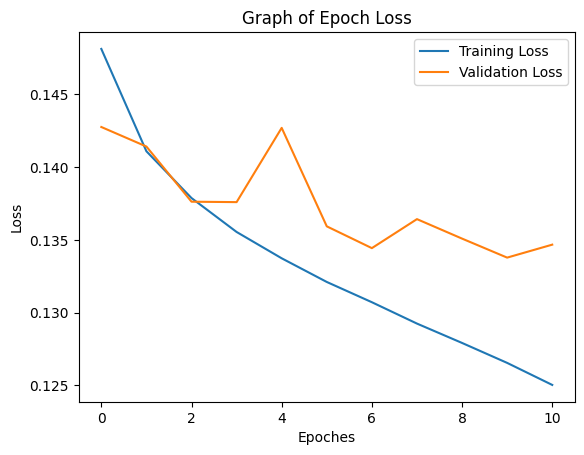

In [ ]:
PlotLearnignCurve()

In [ ]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics as sklm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


def make_pred_multilabel(model, test_path, val_path, images_dir, device):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model
    Args:

        model: densenet-121 from torchvision previously fine tuned to training data
        test_df : dataframe csv file
        PATH_TO_IMAGES:
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    BATCH_SIZE = 32

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    dataset_test = ChestXray8Dataset(img_dir=images_dir,metadata_file=metadata_dir,split_file=test_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor(),  
    normalize]))
    test_loader = torch.utils.data.DataLoader(dataset_test, BATCH_SIZE, shuffle=True)

    dataset_val = ChestXray8Dataset(img_dir=images_dir,metadata_file=metadata_dir,split_file=val_path, transform=transforms.Compose([
        transforms.Resize((224, 224)),          
        transforms.ToTensor(),  
        normalize]))
    val_loader = torch.utils.data.DataLoader(dataset_val, BATCH_SIZE, shuffle=True)





    # criterion = nn.BCELoss().to(device)
    model = model.to(device)
    # to find this thresold, first we get the precision and recall withoit this, from there we calculate f1 score, using f1score, we found this theresold which has best precsision and recall.  Then this threshold activation are used to calculate our binary output.


    PRED_LABEL = ['Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']

    for mode in ["Threshold", "test"]:
        # create empty dfs
        pred_df = pd.DataFrame(columns=["path"])
        bi_pred_df = pd.DataFrame(columns=["path"])
        true_df = pd.DataFrame(columns=["path"])

        if mode == "Threshold":
            loader = val_loader
            Eval_df = pd.DataFrame(columns=["label", 'bestthr'])
            thrs = []

        if mode == "test":
            loader = test_loader
            TestEval_df = pd.DataFrame(columns=["label", 'auc', "auprc"])

            Eval = pd.read_csv("./results/Threshold.csv")
            thrs = [Eval["bestthr"][Eval[Eval["label"] == "Atelectasis"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Cardiomegaly"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Effusion"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Infiltration"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Mass"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Nodule"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Pneumonia"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Pneumothorax"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Consolidation"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Edema"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Emphysema"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Fibrosis"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Pleural_Thickening"].index[0]],
                    Eval["bestthr"][Eval[Eval["label"] == "Hernia"].index[0]]]

        for i, data in enumerate(loader):
            inputs, labels, item = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            true_labels = labels.cpu().data.numpy()

            batch_size = true_labels.shape

            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                probs = outputs.cpu().data.numpy()

            # get predictions and true values for each item in batch
            for j in range(0, batch_size[0]):
                thisrow = {}
                bi_thisrow = {}
                truerow = {}

                truerow["path"] = item[j]
                thisrow["path"] = item[j]
                if mode == "test":
                    bi_thisrow["path"] = item[j]

                    # iterate over each entry in prediction vector; each corresponds to
                    # individual label
                for k in range(len(PRED_LABEL)):
                    thisrow["prob_" + PRED_LABEL[k]] = probs[j, k]
                    truerow[PRED_LABEL[k]] = true_labels[j, k]

                    if mode == "test":
                       bi_thisrow["bi_" + PRED_LABEL[k]] = probs[j, k] >= thrs[k]

                pred_df = pred_df.append(thisrow, ignore_index=True)
                true_df = true_df.append(truerow, ignore_index=True)
                if mode == "test":
                    bi_pred_df = bi_pred_df.append(bi_thisrow, ignore_index=True)

            if (i % 200 == 0):
                print(str(i * BATCH_SIZE))


        for column in true_df:
            if column not in PRED_LABEL:
                continue
            actual = true_df[column]
            pred = pred_df["prob_" + column]
            
            thisrow = {}
            thisrow['label'] = column
            
            if mode == "test":
                bi_pred = bi_pred_df["bi_" + column]            
                thisrow['auc'] = np.nan
                thisrow['auprc'] = np.nan
            else:
                thisrow['bestthr'] = np.nan

            try:
#                 n_booatraps = 1000
#                 rng_seed = int(size / 100)
#                 bootstrapped_scores = []

#                 rng = np.random.RandomState(rng_seed)
#                 for i in range(n_booatraps):
#                     indices = rng.random_integers(0, len(actual.as_matrix().astype(int)) - 1, len(pred.as_matrix()))
#                     if len(np.unique(actual.as_matrix().astype(int)[indices])) < 2:
#                         continue

#                     score = sklm.roc_auc_score(
#                         actual.as_matrix().astype(int)[indices], pred.as_matrix()[indices])
#                     bootstrapped_scores.append(score)

#                 thisrow['auc'] = np.mean(bootstrapped_scores)
                

                if mode == "test":
                    thisrow['auc'] = sklm.roc_auc_score(
                        actual.as_matrix().astype(int), pred.as_matrix())

                    thisrow['auprc'] = sklm.average_precision_score(
                        actual.as_matrix().astype(int), pred.as_matrix())
                else:

                    p, r, t = sklm.precision_recall_curve(actual.as_matrix().astype(int), pred.as_matrix())
                    # Choose the best threshold based on the highest F1 measure
                    f1 = np.multiply(2, np.divide(np.multiply(p, r), np.add(r, p)))
                    bestthr = t[np.where(f1 == max(f1))]

                    thrs.append(bestthr)
                    thisrow['bestthr'] = bestthr[0]


            except BaseException:
                print("can't calculate auc for " + str(column))

            if mode == "Threshold":
                Eval_df = Eval_df.append(thisrow, ignore_index=True)

            if mode == "test":
                TestEval_df = TestEval_df.append(thisrow, ignore_index=True)

        pred_df.to_csv(results_dir/"preds.csv", index=False)
        true_df.to_csv(results_dir/"True.csv", index=False)


        if mode == "Threshold":
            Eval_df.to_csv(results_dir/"Threshold.csv", index=False)

        if mode == "test":
            TestEval_df.to_csv(results_dir/"TestEval.csv", index=False)
            bi_pred_df.to_csv(results_dir/"bipred.csv", index=False)

    
    print("AUC ave:", TestEval_df['auc'].sum() / 14.0)

    print("done")

    return pred_df, Eval_df, bi_pred_df, TestEval_df  # , bi_pred_df , Eval_bi_df


In [ ]:
CheckPointData = torch.load(results_dir/'checkpoint')
model = CheckPointData['model']

make_pred_multilabel(model, test_path, val_path, images_dir, device)


C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_22144\4188217579.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CheckPointData = torch.load(results_dir/'checkpoint')


ValueError: not enough values to unpack (expected 3, got 2)